In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_pred = os.path.join(pth, 'data', 'modeling', 'regression', 'predict')
# pth_out = os.path.join(pth, 'figures', 'cancer', 'CCCA')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_pred, 'CCCA.h5ad'))
adata

AnnData object with n_obs × n_vars = 1438665 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'viral', 'location', 'cancer_type', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'core

In [4]:
# average latent z (samples)
by = ['Category', 'Disease', 'source', 'sample']
df_plt = (adata.obs.groupby(by, observed = True)
          .latent_z_reg.mean().reset_index())

/tmp/ipykernel_1371384/2823118366.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),


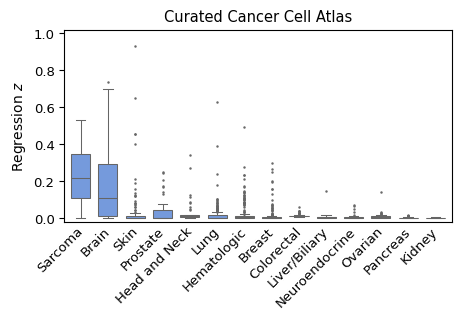

In [5]:
# plot categories
xvar, yvar = 'Category', 'latent_z_reg'
fig, ax = plt.subplots(1, 1, figsize = (5, 2.5))
order = (df_plt.groupby(xvar, observed = True)[yvar]
         .mean().sort_values(ascending = False).index)
sns.boxplot(df_plt,
            x = xvar,
            y = yvar,
            order = order,
            color = 'cornflowerblue',
            width = .7,
            fliersize = .75,
            linewidth = .75,
            ax = ax)
pad, xlim = (.1, .02), ax.get_xlim()
ax.set_xlim(xlim[0] - pad[0], xlim[1] + pad[0])
ax.set_ylim(-pad[1], 1 + pad[1])
yticks = np.arange(0, 1.1, .2).round(1)
ax.set_yticks(yticks, yticks, size = 9.5)
ax.set_title('Curated Cancer Cell Atlas', size = 10.5)
ax.set_ylabel(r'Regression $z$', size = 10)
ax.set_xlabel('')
ax.tick_params('x', size = 0, pad = 5)
ax.set_xticklabels(ax.get_xticklabels(),
                   size = 9.5, rotation = 45,
                   rotation_mode = 'anchor',
                   ha = 'right', va = 'center')
# fn = os.path.join(pth_out, 'category.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
plt.show()

/tmp/ipykernel_1371384/2985289227.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),


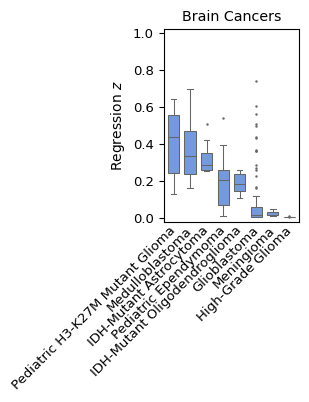

In [7]:
xvar = 'Disease'
df_brain = df_plt.loc[df_plt.Category == 'Brain'].copy()
# df_brain[xvar] = df_brain[xvar].map({
#     'Glioblastoma'                    : 'High-Grade Glioma',
#     'High-Grade Glioma'               : 'High-Grade Glioma',
#     'Pediatric H3-K27M Mutant Glioma' : 'High-Grade Glioma',
#     'IDH-Mutant Astrocytoma'          : 'Low-Grade Glioma',
#     'IDH-Mutant Oligodendroglioma'    : 'Low-Grade Glioma',
#     'Medulloblastoma'                 : 'Medulloblastoma',
#     'Meningioma'                      : 'Meningioma',
#     'Pediatric Ependymoma'            : 'Ependymoma'})

# plot brain cancers
fig, ax = plt.subplots(1, 1, figsize = (1.75, 2.5))
order = (df_brain.groupby(xvar, observed = True)[yvar]
         .mean().sort_values(ascending = False).index)
sns.boxplot(df_brain,
            x = xvar,
            y = yvar,
            order = order,
            color = 'cornflowerblue',
            width = .675,
            fliersize = .75,
            linewidth = .75,
            ax = ax)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0] - pad[0], xlim[1] + pad[0])
ax.set_ylim(-pad[1], 1 + pad[1])
ax.set_yticks(yticks, yticks, size = 9.5)
ax.set_title('Brain Cancers', size = 10.25)
ax.set_ylabel(r'Regression $z$', size = 10)
ax.set_xlabel('')
ax.tick_params('x', size = 0, pad = 5)
ax.set_xticklabels(ax.get_xticklabels(),
                   size = 9.5, rotation = 45,
                   rotation_mode = 'anchor',
                   ha = 'right', va = 'center')
# fn = os.path.join(pth_out, 'brain.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
plt.show()